# Imports  

In [1]:
from gliderad2cp import process_adcp
from gliderad2cp.download_example_data import data_source


# Begin ADCP Data Processing

Set paths to input files and specify options

In [2]:
#profile_range = "10_to_210" # Medium dataset
profile_range = "10_to_1170" # Full dataset - Slow to process!
#profile_range = "160_to_210" # Small dataset


glider_pqt_path = data_source.get_url(f"glider_profiles_{profile_range}.pqt")
data_source.fetch(f"adcp_profiles_{profile_range}.nc")
adcp_path = str(data_source.path / f"adcp_profiles_{profile_range}.nc")


options = {
    'debug_plots' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    'plots_directory': 'plots',
    }


## Load ADCP data and add necessary glider variables

In [3]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)

Loaded https://zenodo.org/record/8431329/files/glider_profiles_10_to_1170.pqt
2023-10-11 09:26:09 : Finished loading ADCP data
2023-10-11 09:26:09 : Added glider variables
2023-10-11 09:26:09 : top mounted: True


# Start QC Calculate depth of each individual measurement


2023-10-11 09:26:10 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)


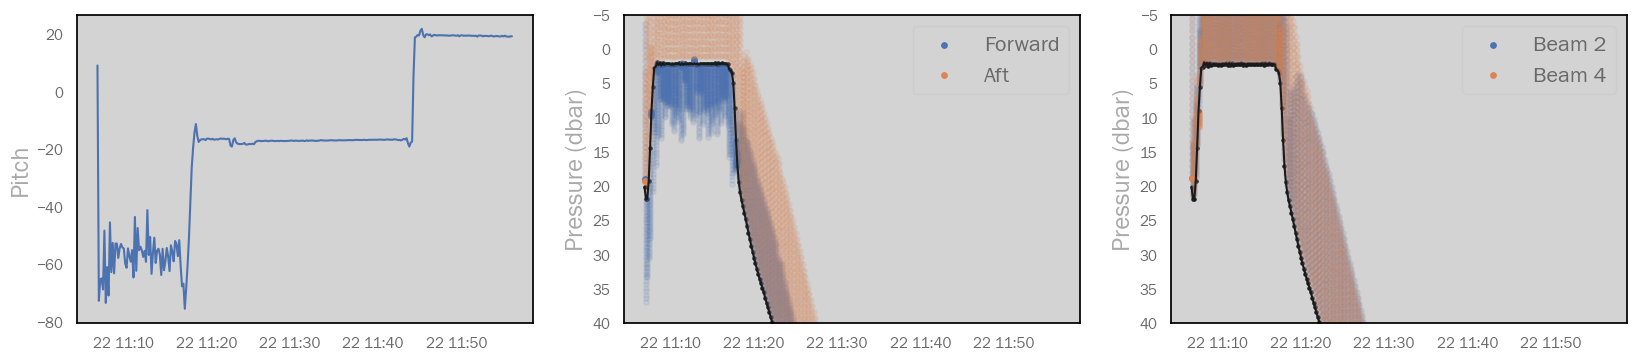

In [4]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

In [5]:
## ADJUST DISTANCE BASED ON SOUNDSPEED !

## Correct ADCP Heading

        <total-intensity units="nT">51038</total-intensity>

Target = 510.38
Optimization terminated successfully.
         Current function value: 1.645016
         Iterations: 983
         Function evaluations: 1397
[[ 8.20448633e-01 -1.64953428e-02 -2.08581743e-02]
 [ 3.23783133e-05  8.62748703e-01 -1.54289856e-02]
 [-9.55037666e-03 -7.56947168e-03  8.52939525e-01]]
[ 0.07603735 -0.04316668  0.01676393]
2023-10-11 09:26:30 : Corrected heading and accounted for declination


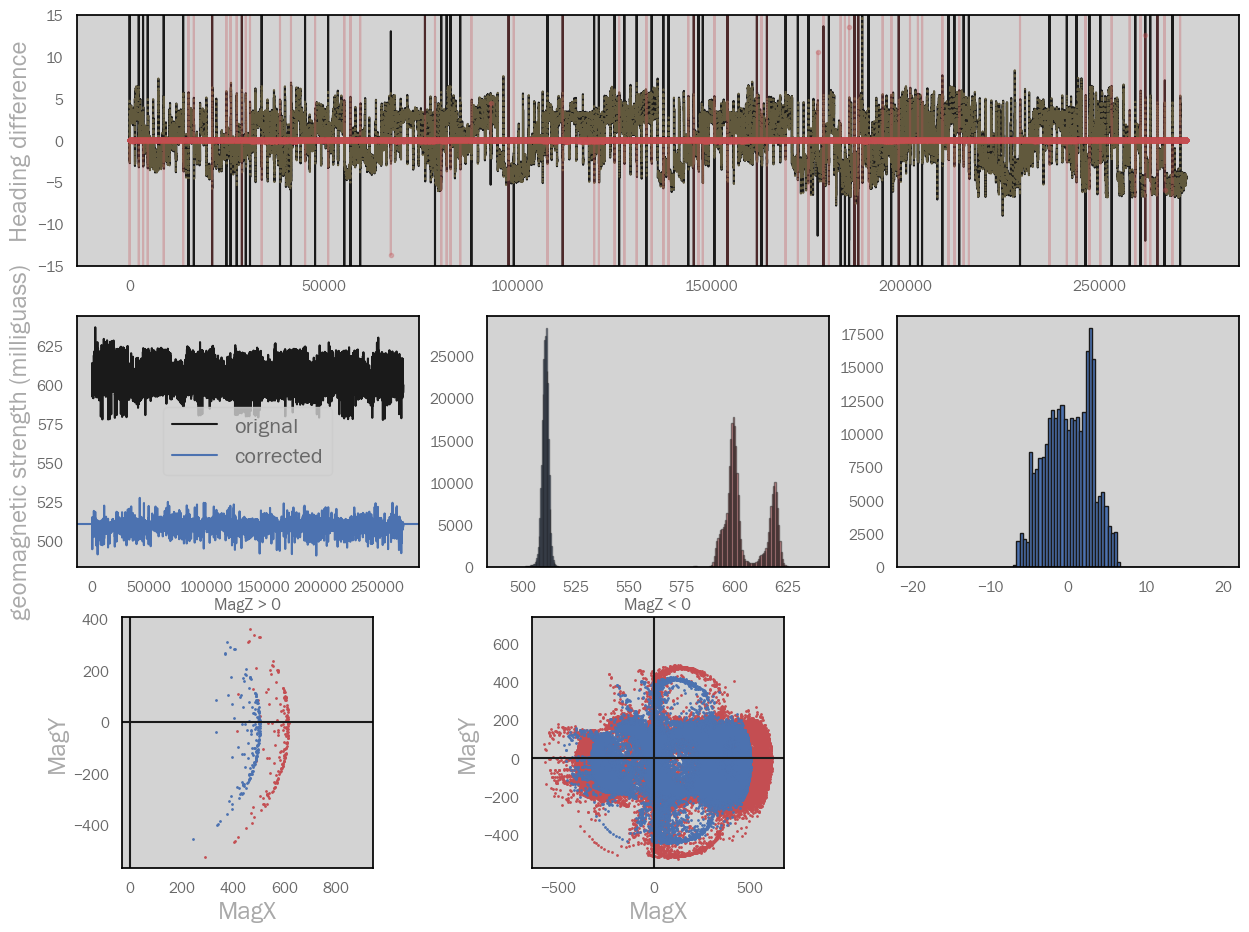

In [6]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## Perform soundspeed correction

In [7]:
ADCP = process_adcp.soundspeed_correction(ADCP)

2023-10-11 09:26:32 : Corrected beam 1 velocity for sound speed.
2023-10-11 09:26:32 : Corrected beam 2 velocity for sound speed.
2023-10-11 09:26:32 : Corrected beam 3 velocity for sound speed.
2023-10-11 09:26:32 : Corrected beam 4 velocity for sound speed.


## Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

2023-10-11 09:26:49 : Beam 1 correlation: 43.7% removed
2023-10-11 09:26:49 : Beam 1 amplitude: 0.7% removed
2023-10-11 09:26:49 : Beam 1 velocity: 1.7% removed
2023-10-11 09:26:49 : Beam 2 correlation: 44.8% removed
2023-10-11 09:26:49 : Beam 2 amplitude: 0.7% removed
2023-10-11 09:26:49 : Beam 2 velocity: 1.8% removed
2023-10-11 09:26:50 : Beam 3 correlation: 45.9% removed
2023-10-11 09:26:50 : Beam 3 amplitude: 0.6% removed
2023-10-11 09:26:50 : Beam 3 velocity: 2.1% removed
2023-10-11 09:26:50 : Beam 4 correlation: 43.8% removed
2023-10-11 09:26:50 : Beam 4 amplitude: 0.7% removed
2023-10-11 09:26:50 : Beam 4 velocity: 1.7% removed


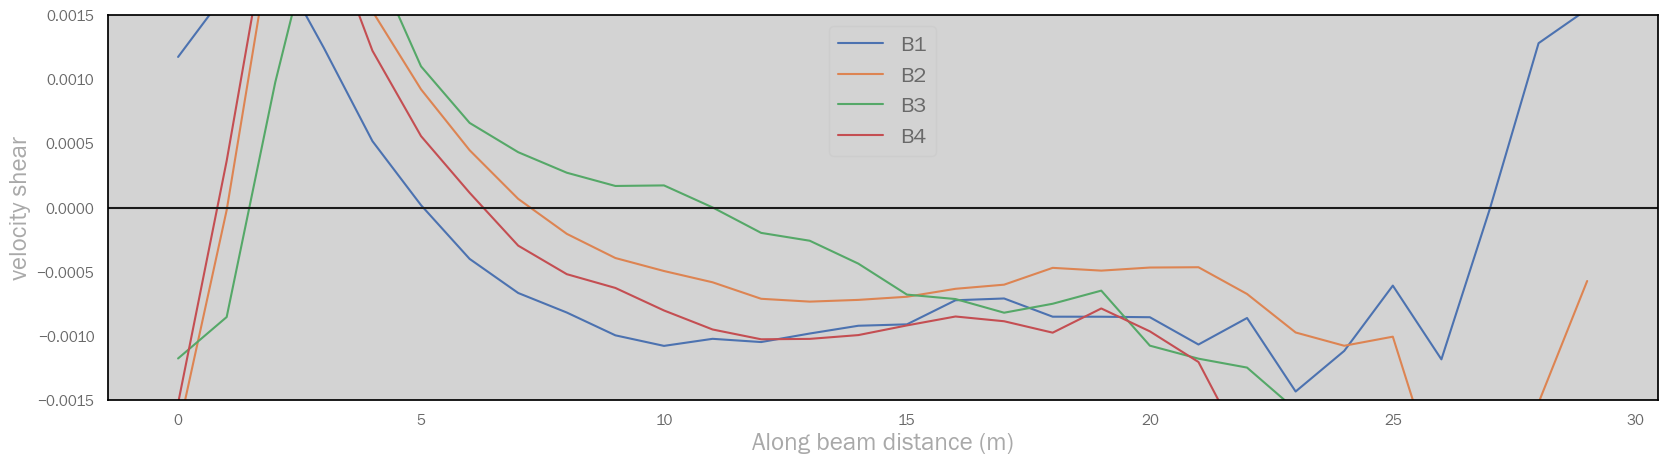

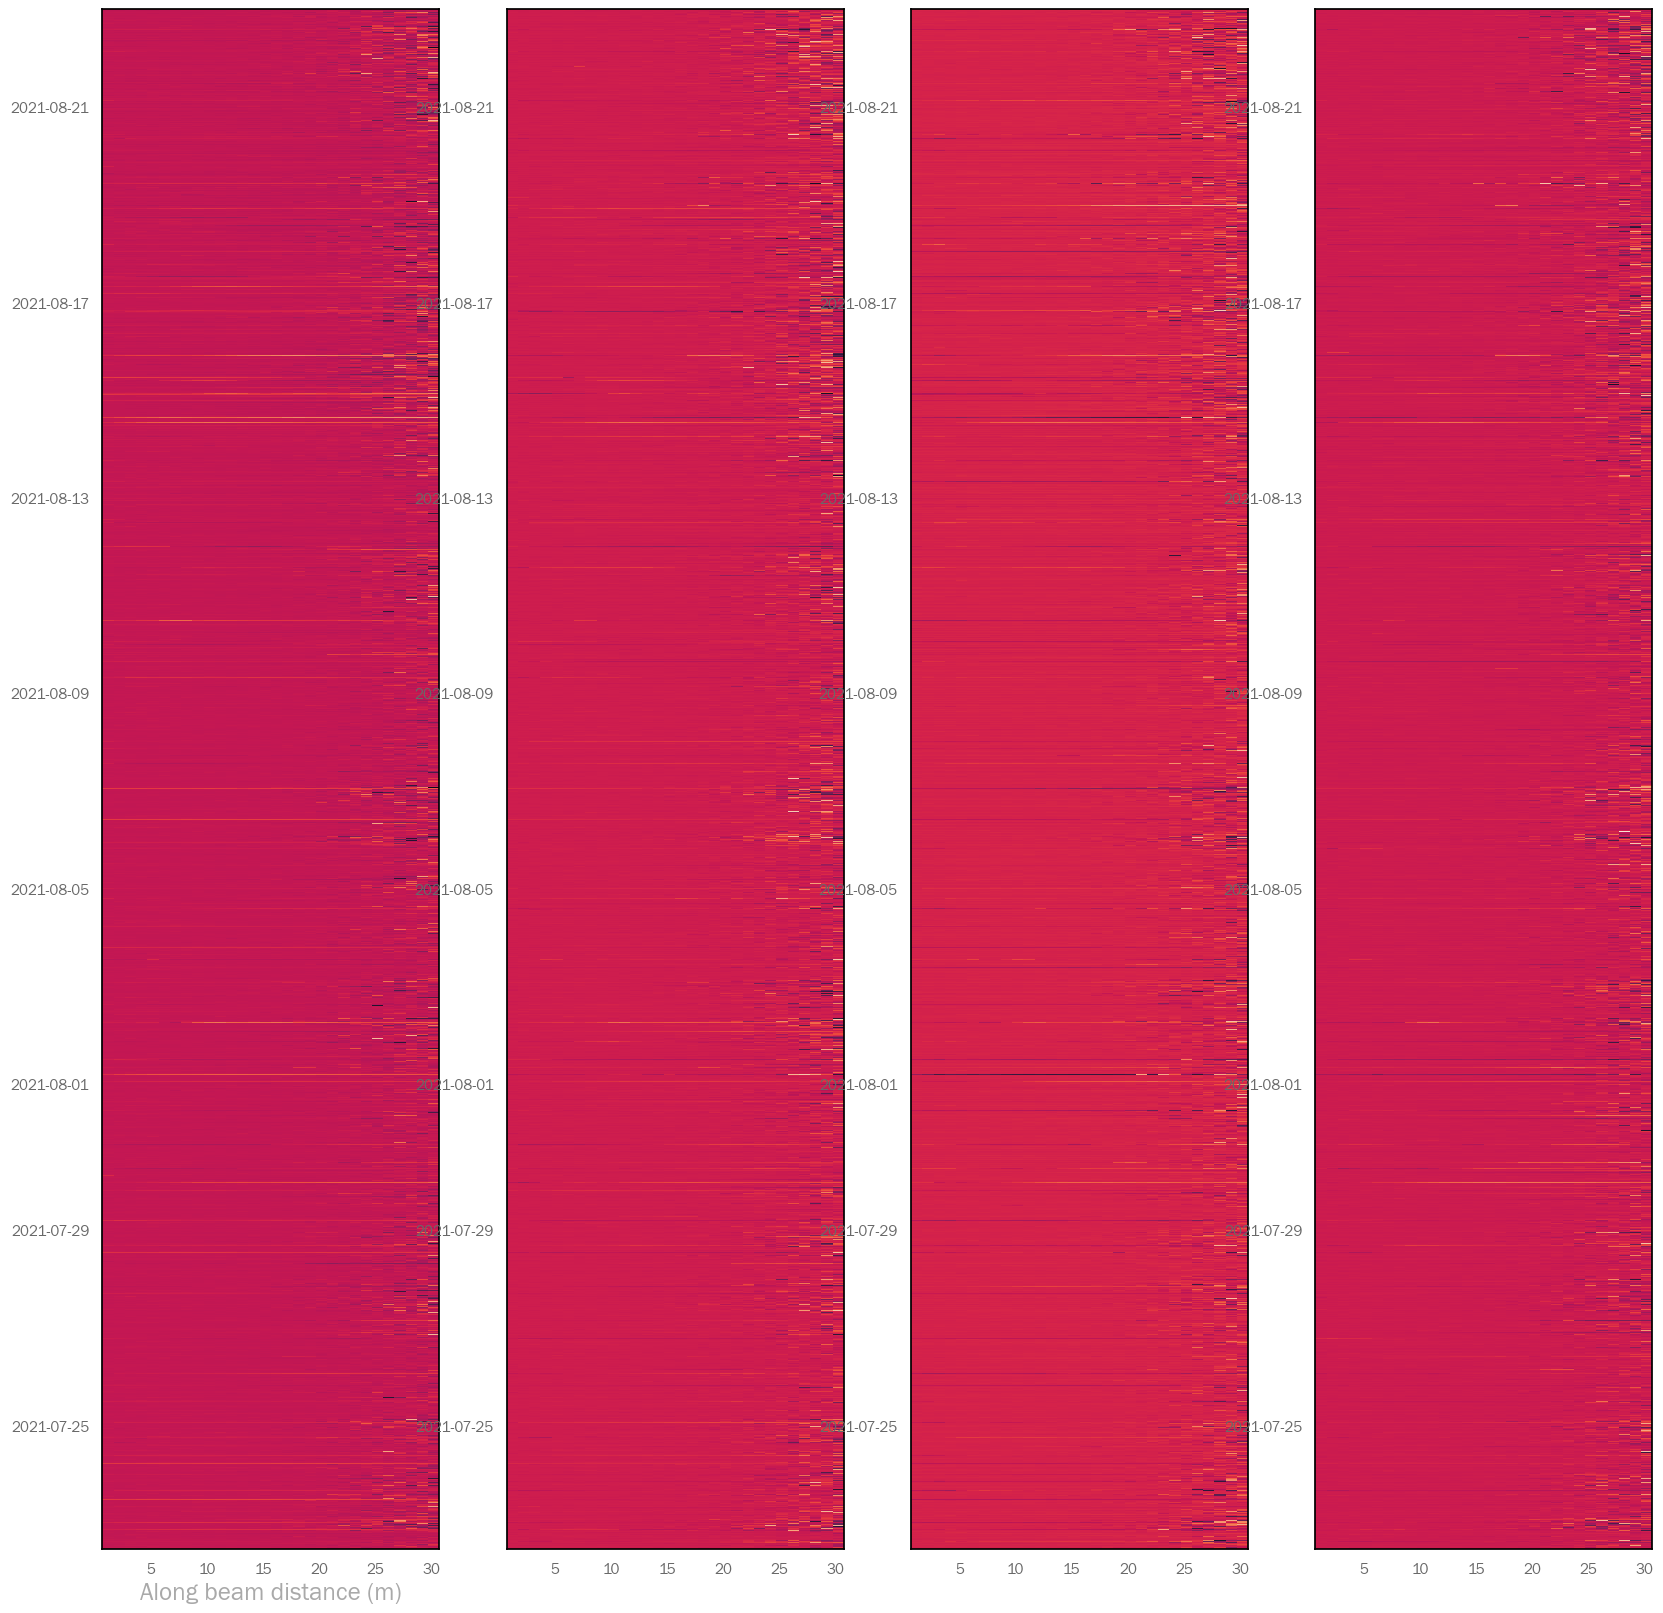

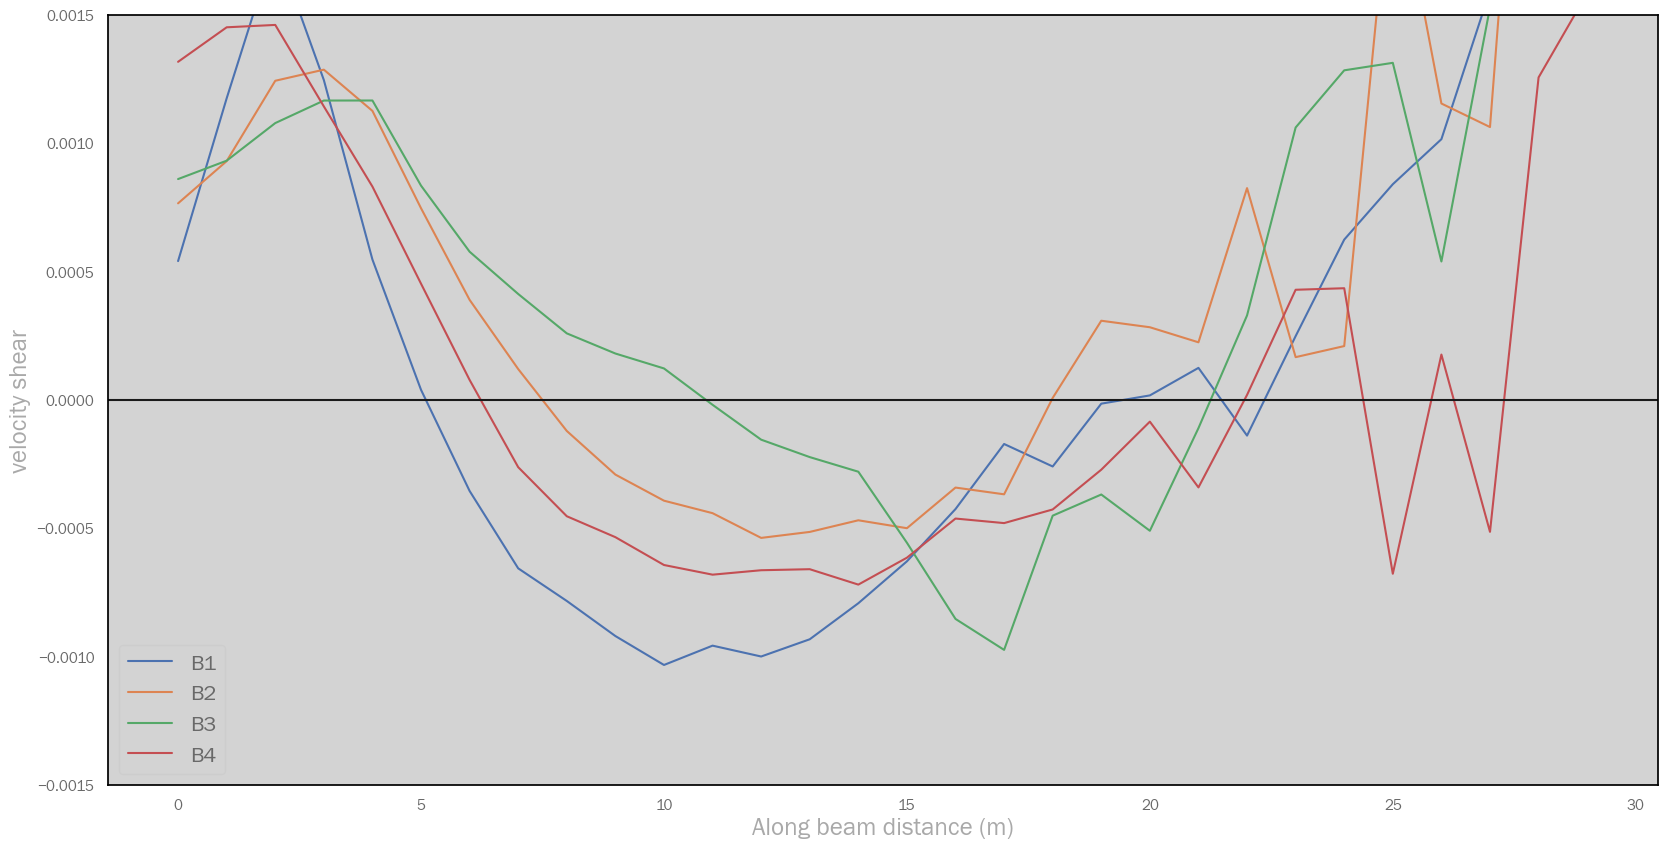

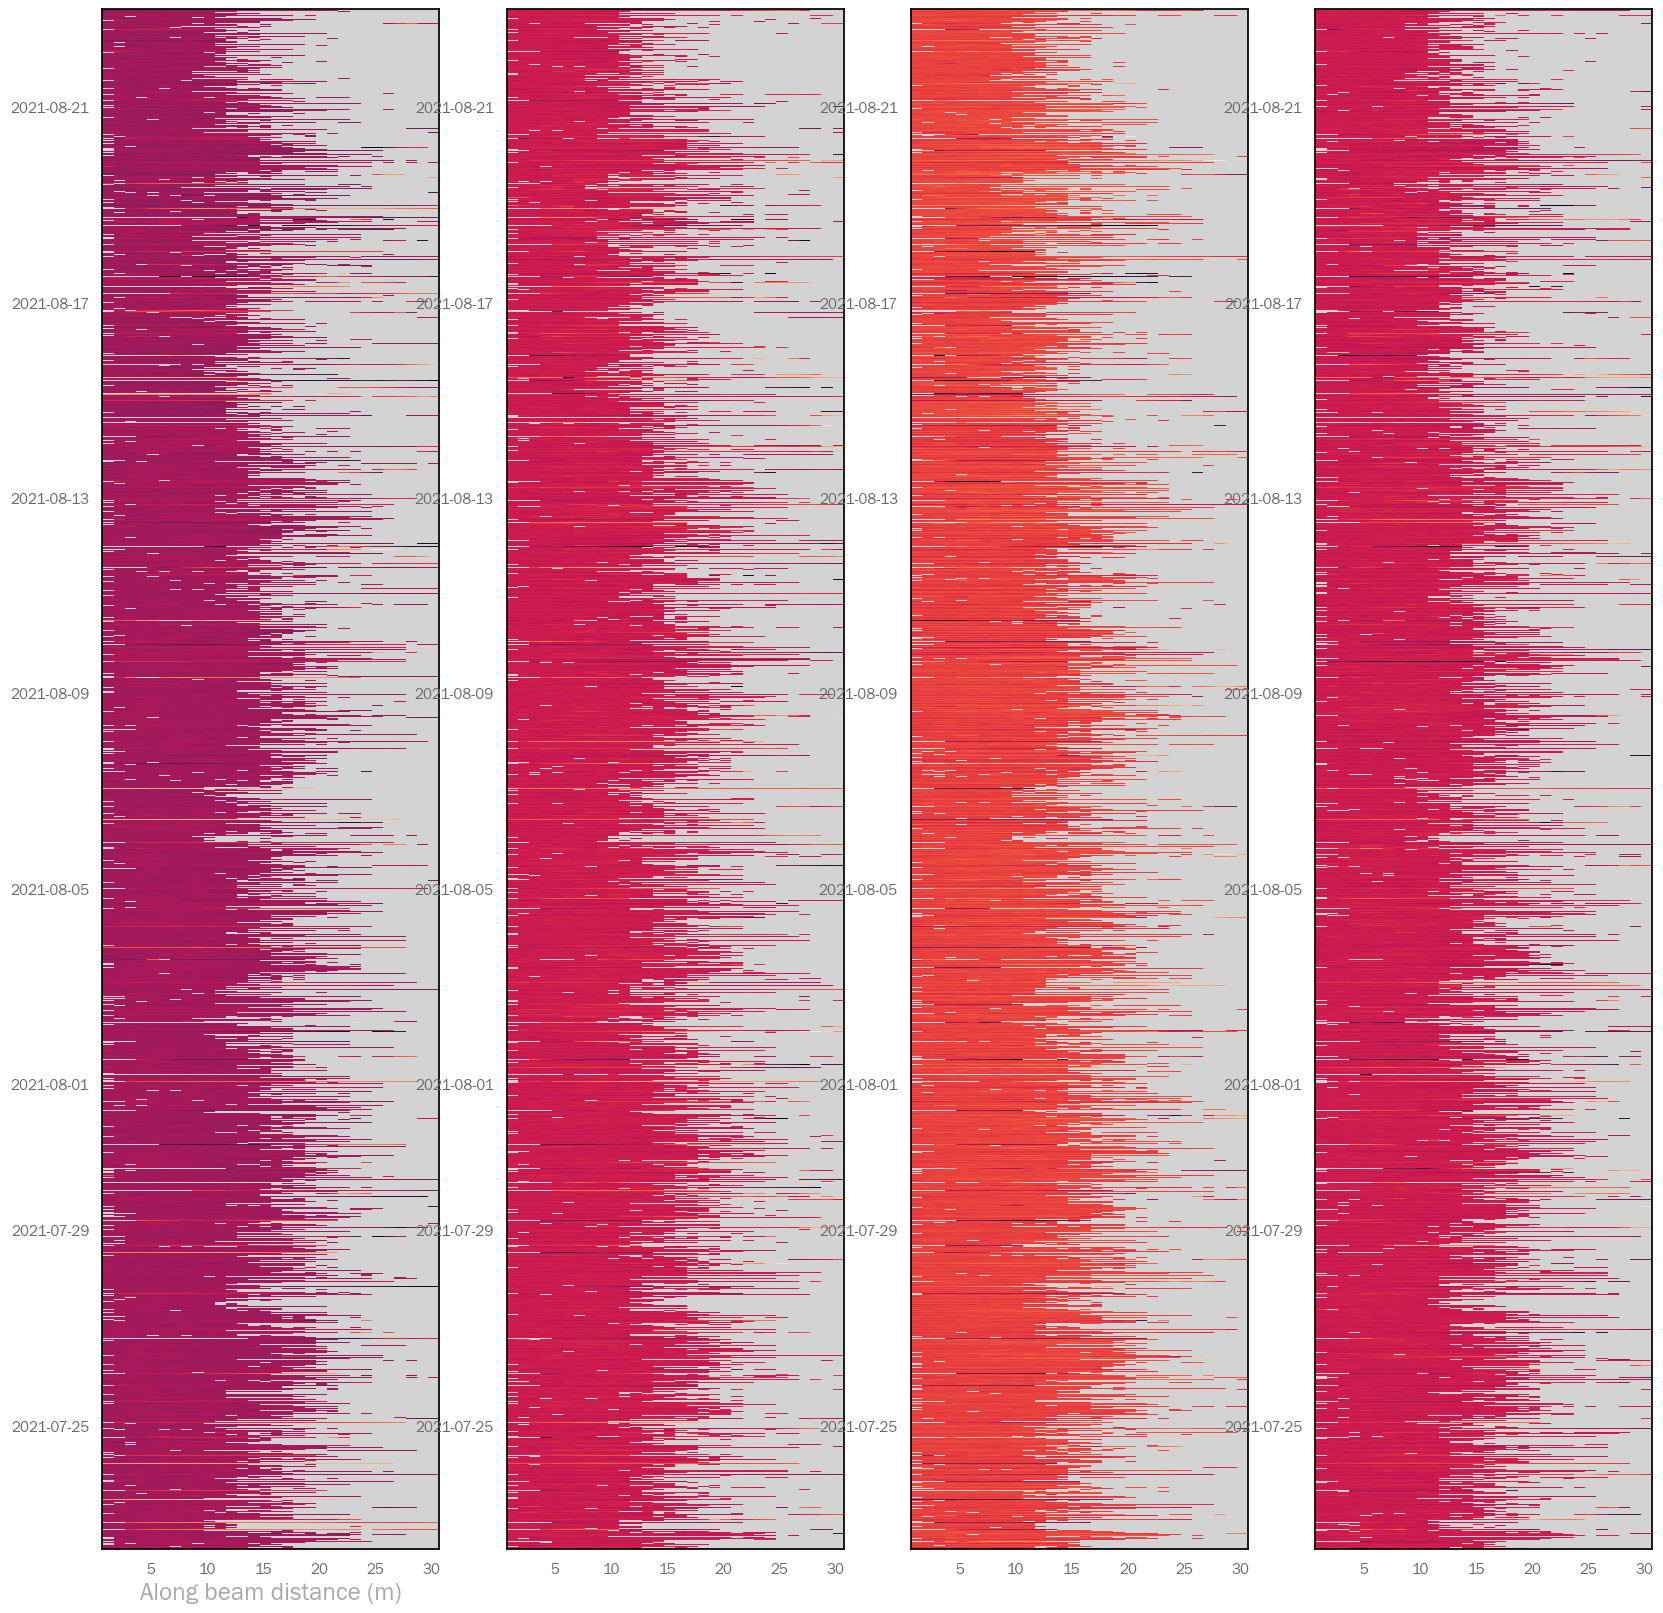

In [8]:
ADCP = process_adcp.remove_outliers(ADCP, options)

Should we interpolate over bad data? Reconstruct missing bins in profiles?

# How many good data per bin?

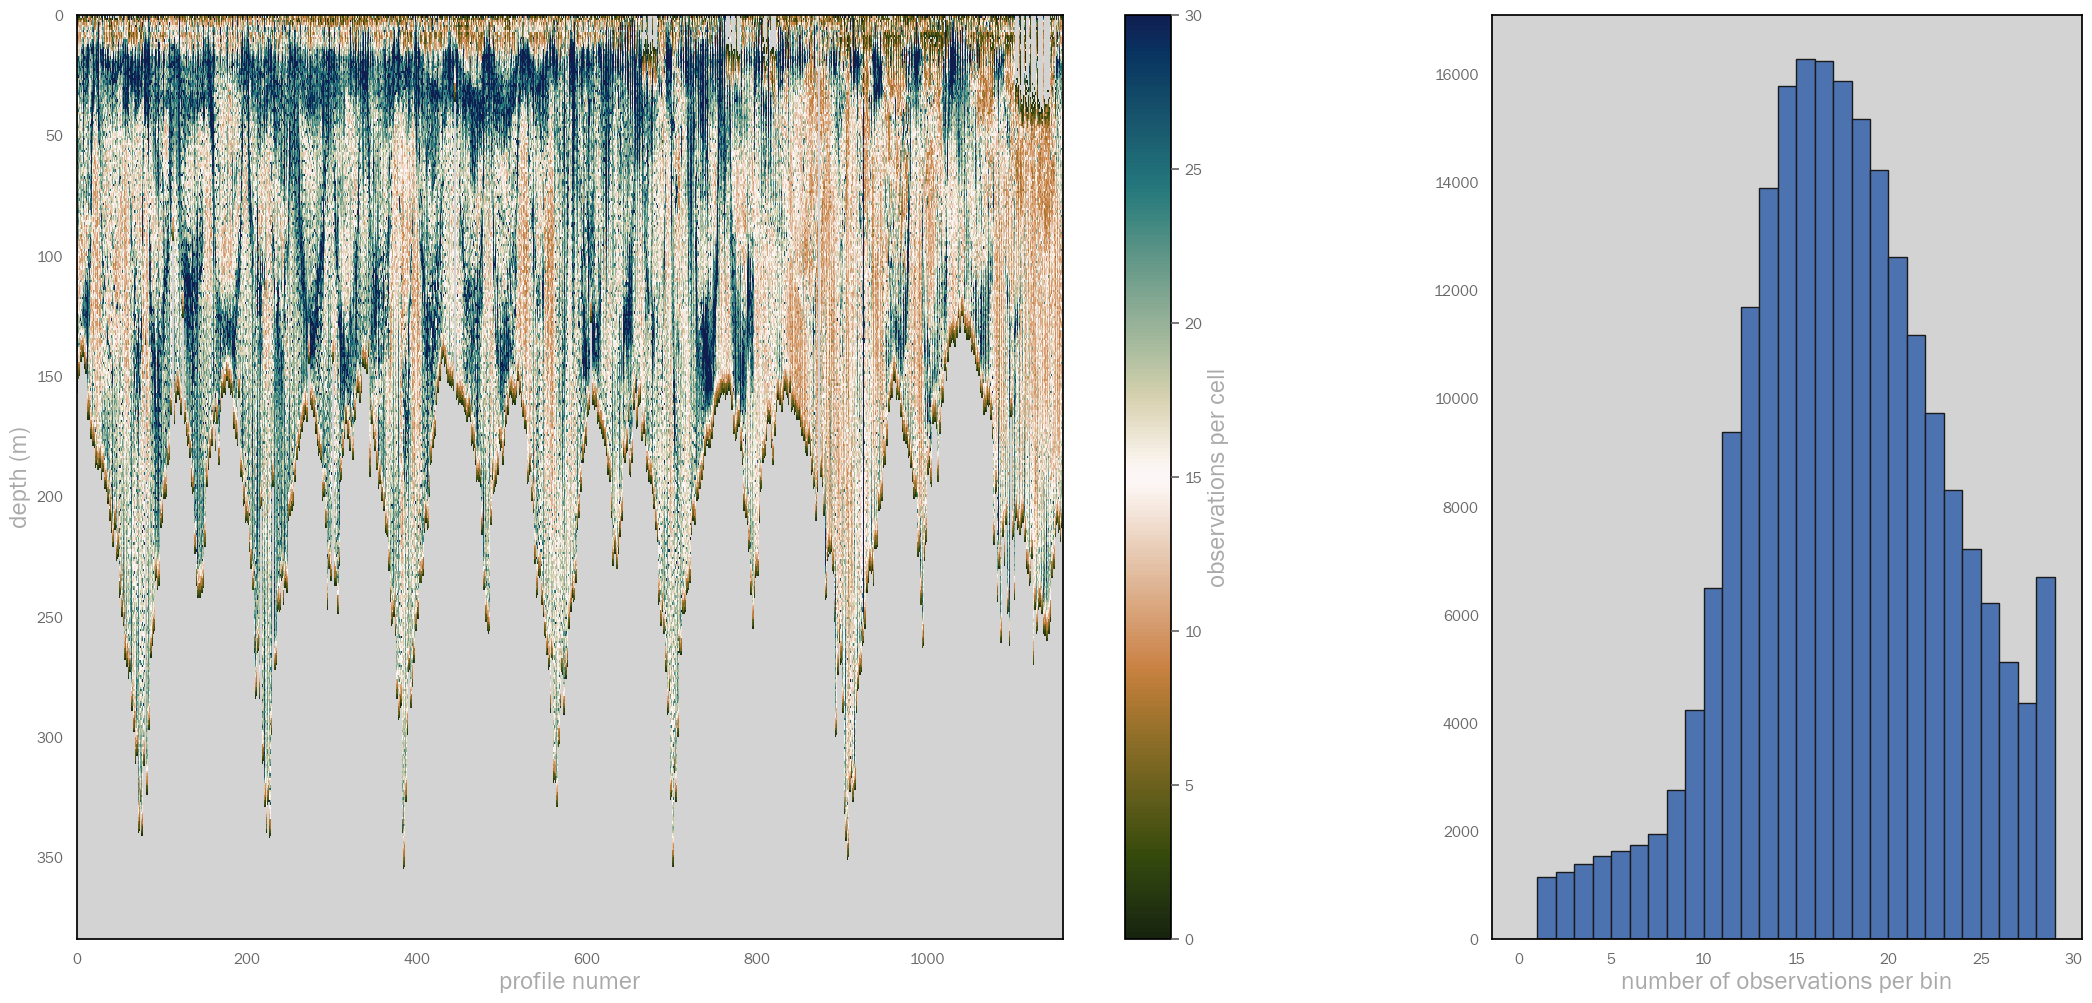

In [9]:
process_adcp.plot_data_density(ADCP, options)

### Correct shear bias

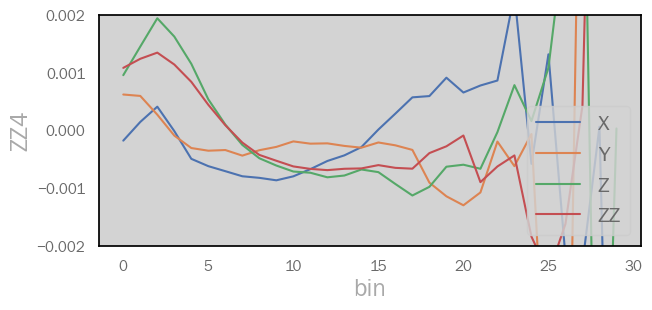

In [10]:
ADCP = process_adcp.correct_shear(ADCP, options)

## 3.4. Correct ADCP acoustic backscatter data (TODO)

/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:852: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  glider.salinity.interpolate('index').fillna(method='bfill').values,
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:855: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  glider.temperature.interpolate('index').fillna(


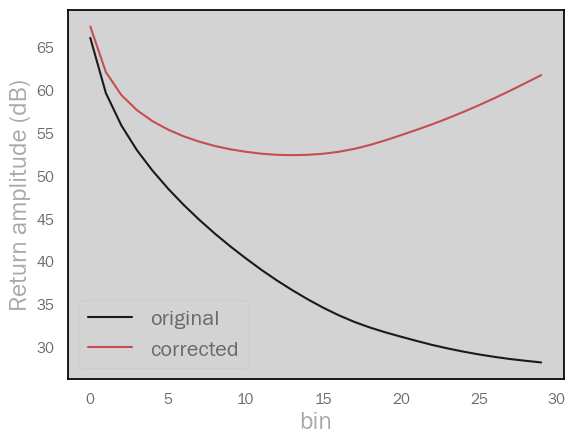

In [12]:
ADCP = process_adcp.correct_backscatter(ADCP, data, options)

## 3.5. Remap 3-beam configuration onto isobars

Using the following depth offsets:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5]
 
Running gridding on all 4 beams:
2023-10-11 09:27:50 : Calculating beam 1
2023-10-11 09:27:59 : Calculating beam 2
2023-10-11 09:28:07 : Calculating beam 3
2023-10-11 09:28:15 : Calculating beam 4


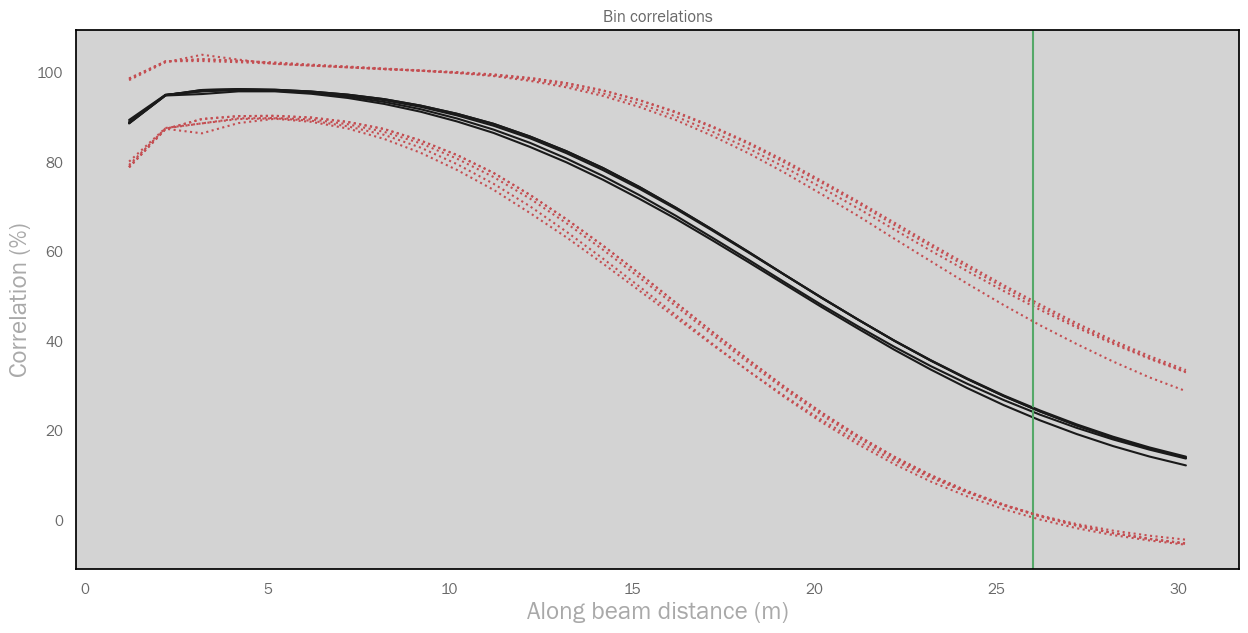

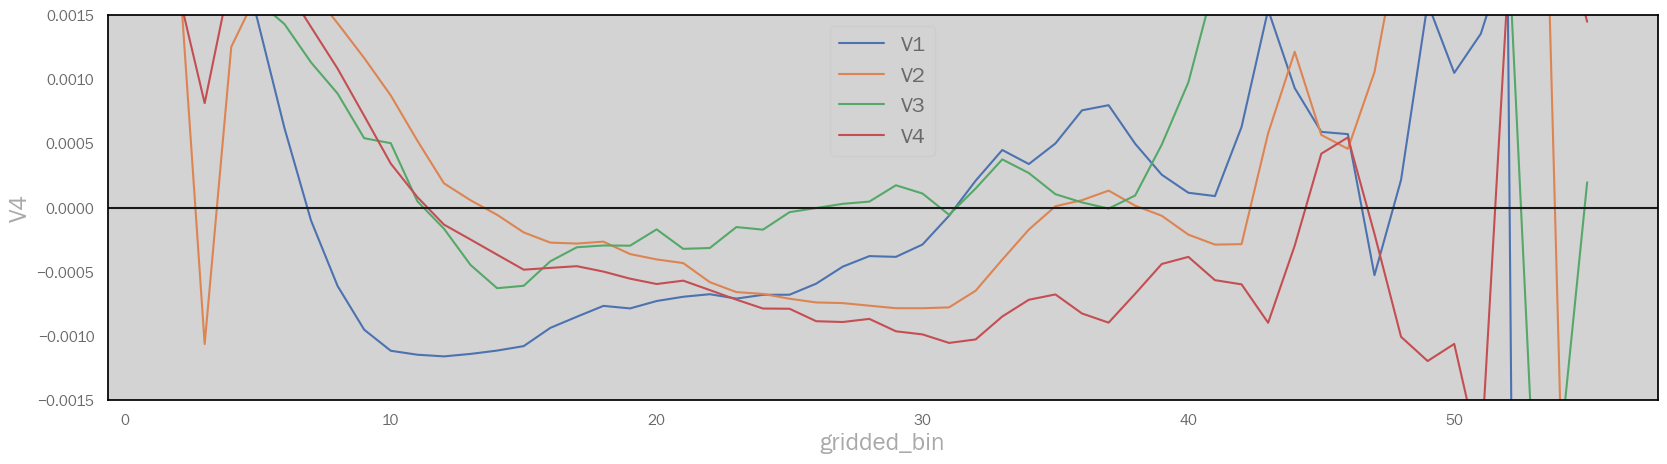

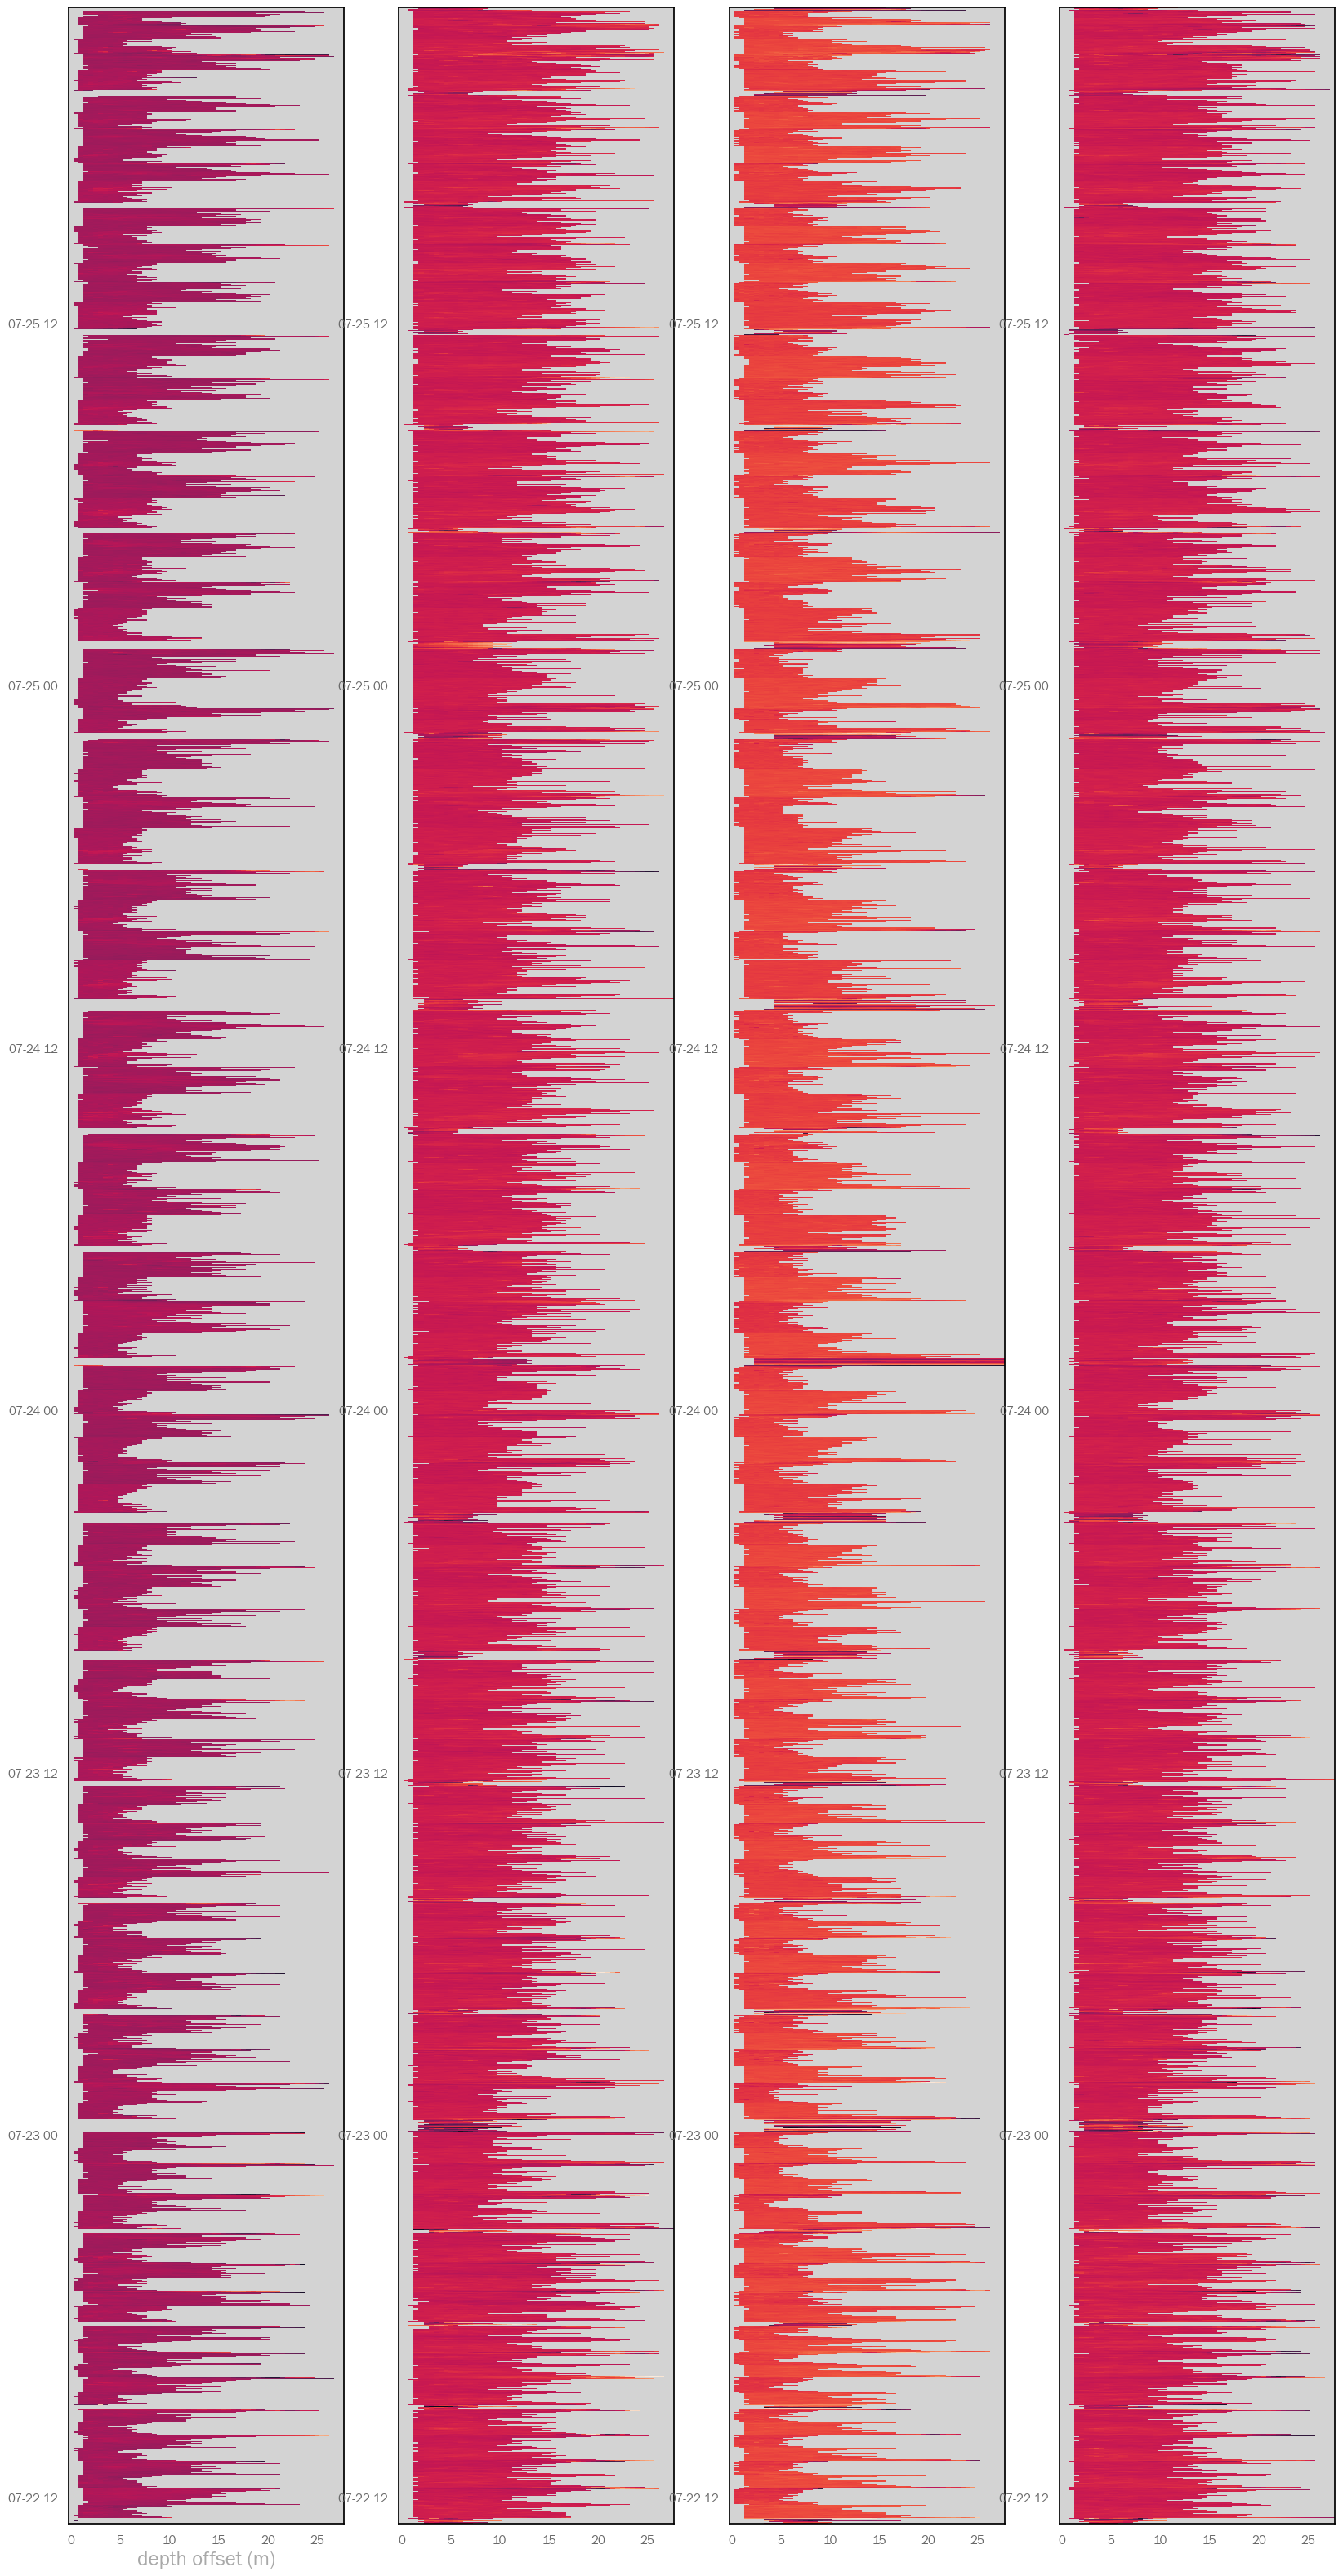

In [13]:
ADCP = process_adcp.regridADCPdata(ADCP, options)

## 3.6. Transform beams to XYZ and ENU velocities

Assuming ADCP is top mounted
2023-10-11 09:28:35 : Calculating X,Y,Z from isobaric 3-beam measurements.


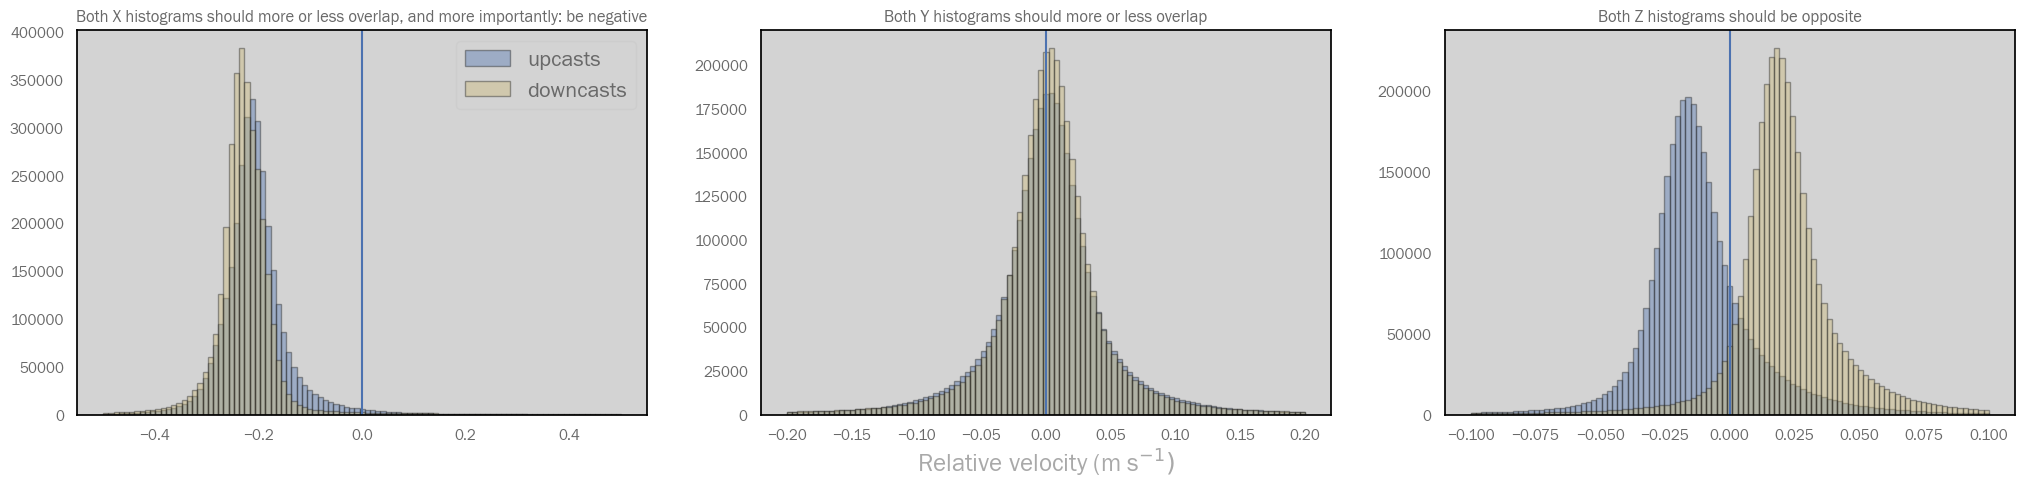

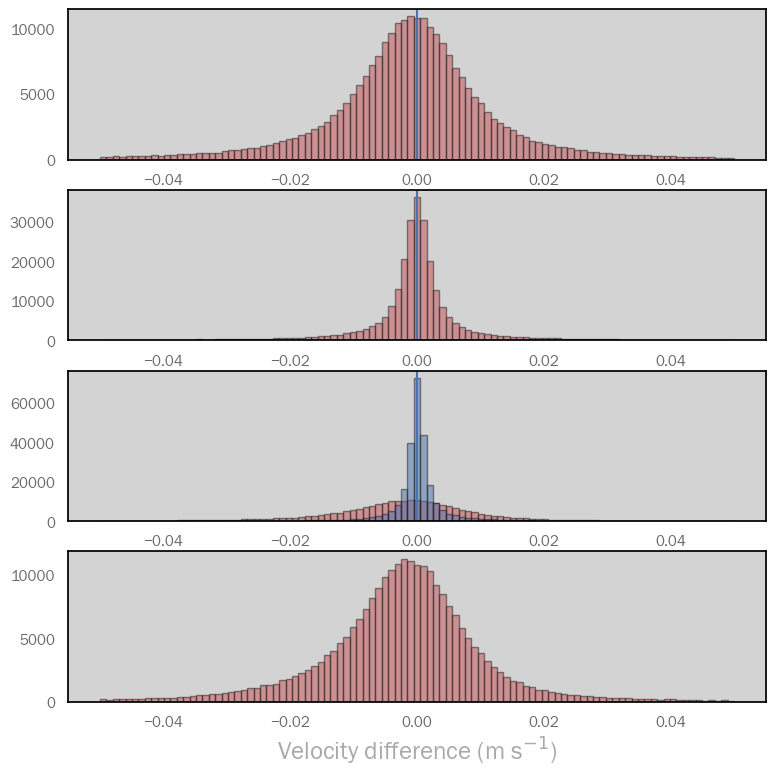

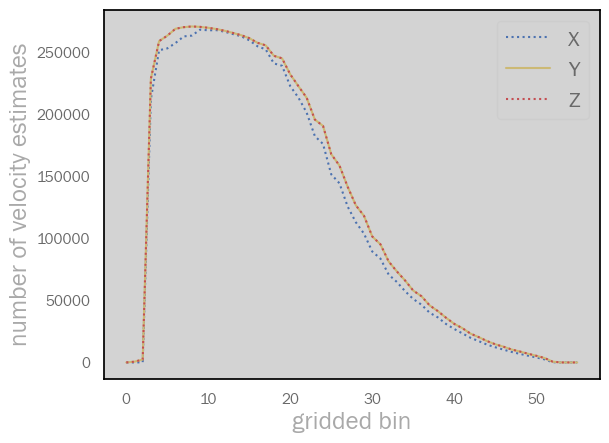

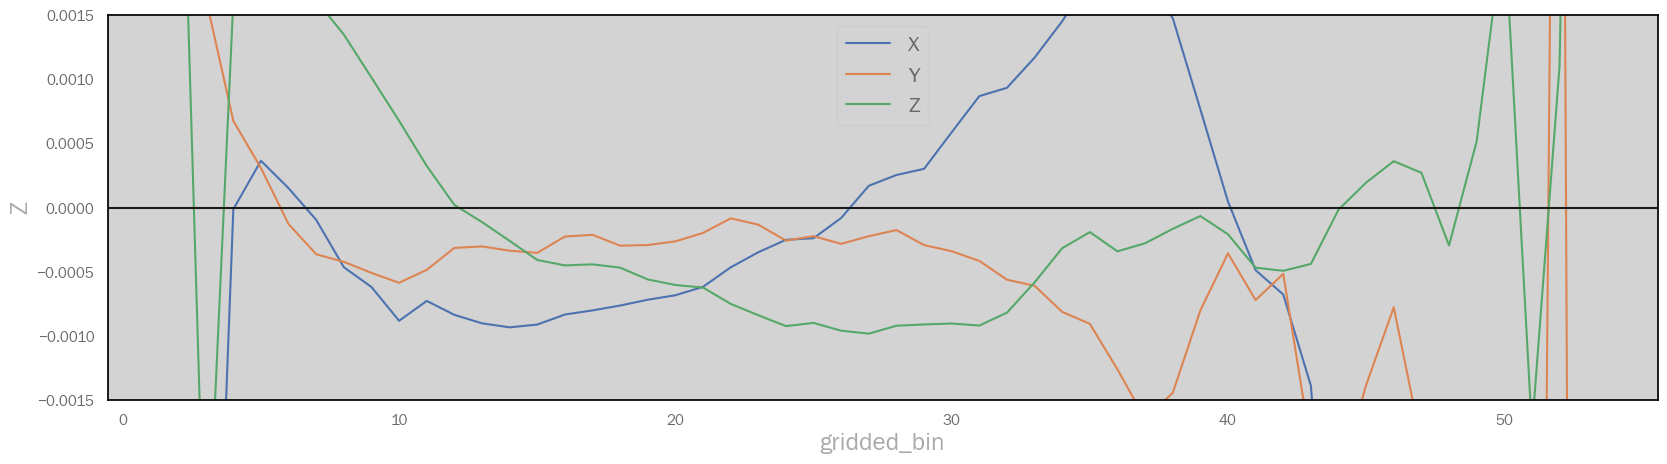

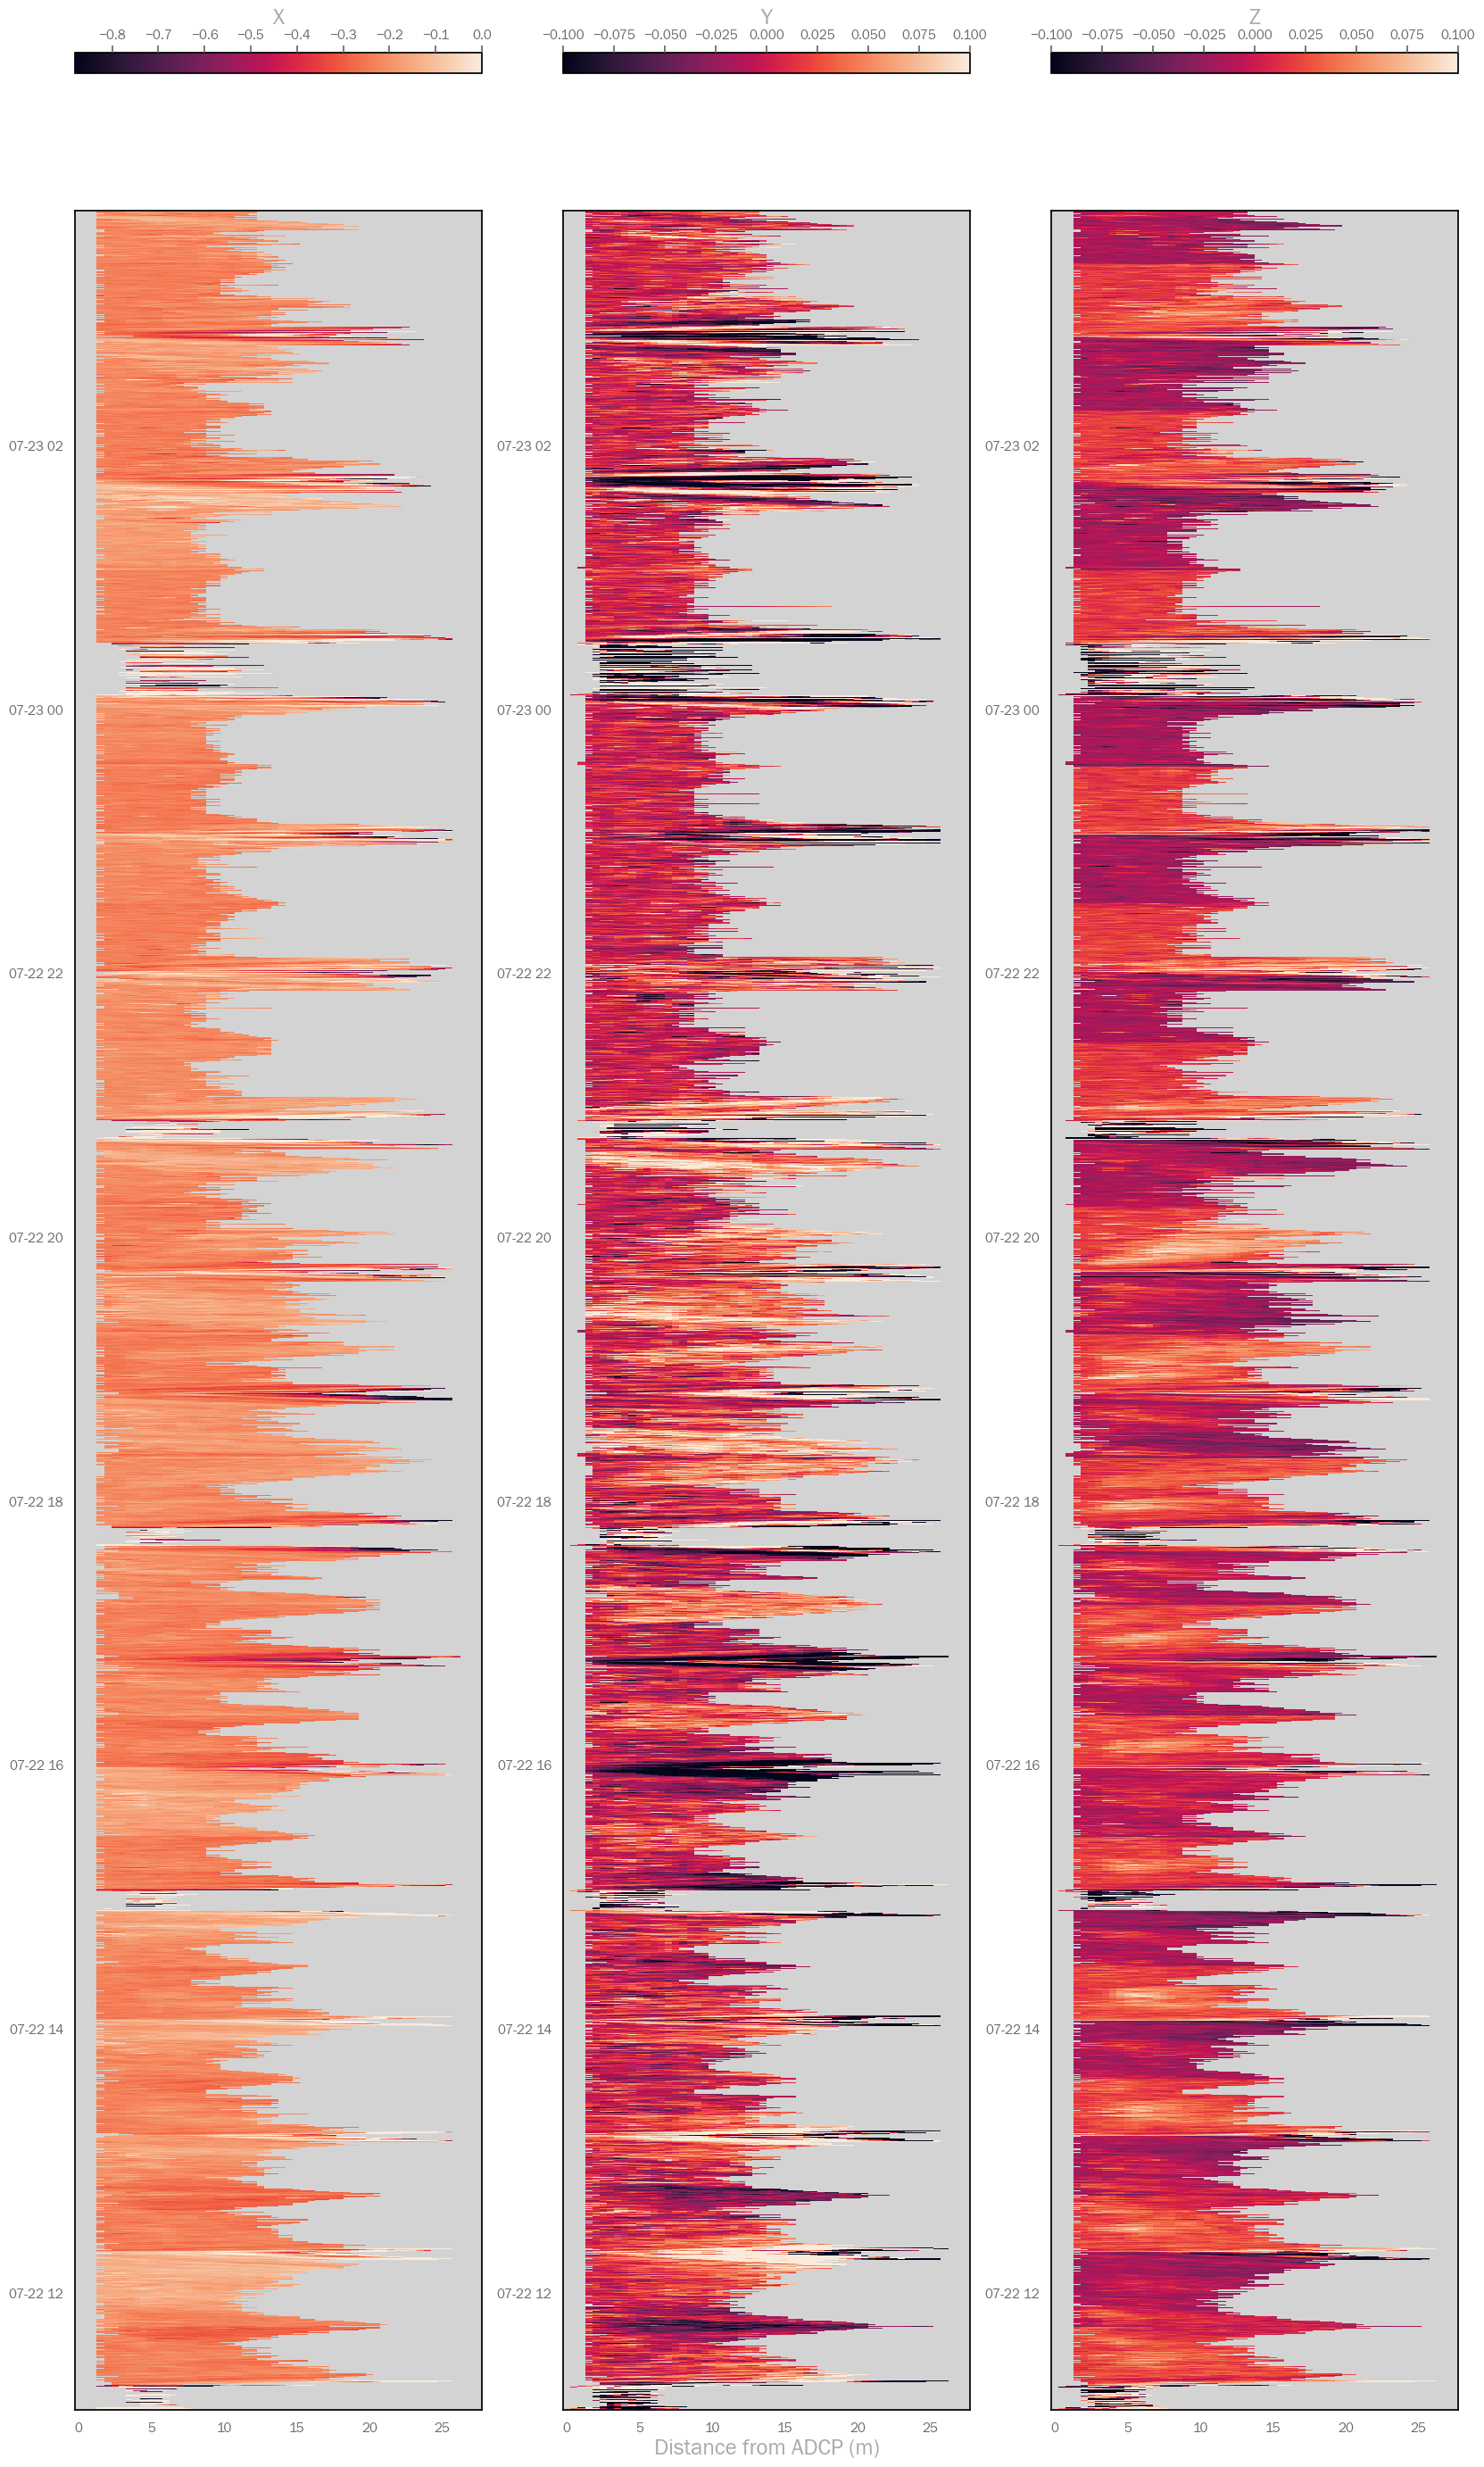

In [14]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

2023-10-11 09:28:40 : Converted from XYZ to ENU


/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:130: FutureWarning: The provided callable <function nanmean at 0x7f14685c27a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  _tmp = raw.groupby(['xbins', 'ybins'])['v'].agg(fn)


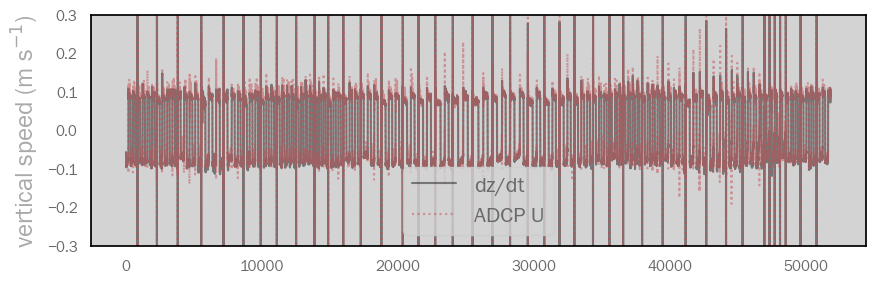

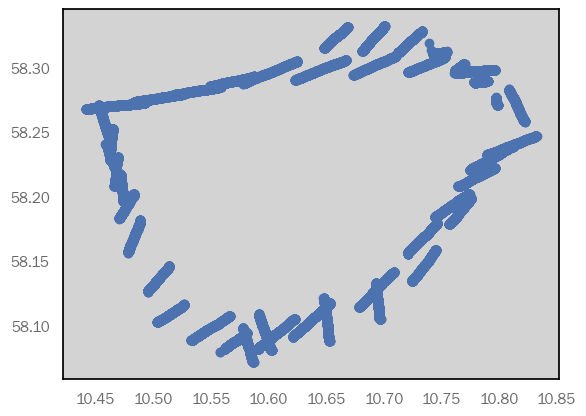

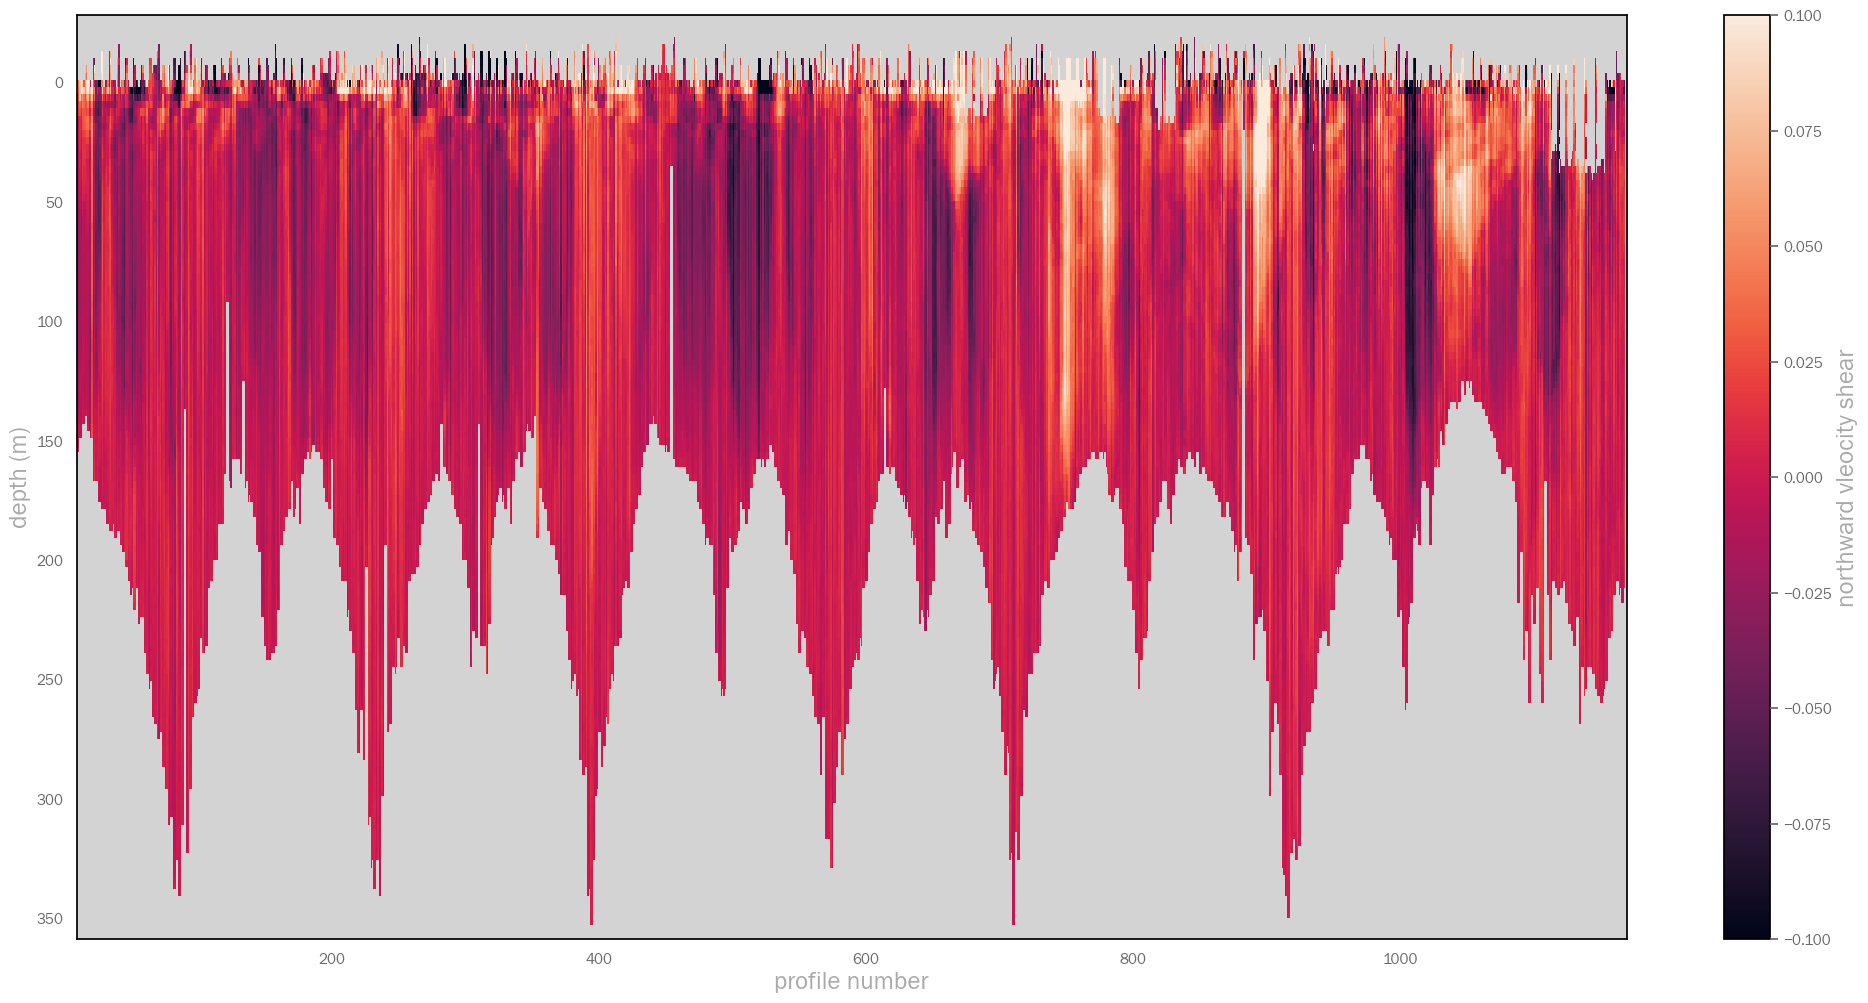

In [15]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

## Check if errors in the above are related to motor movements?

129332 125357


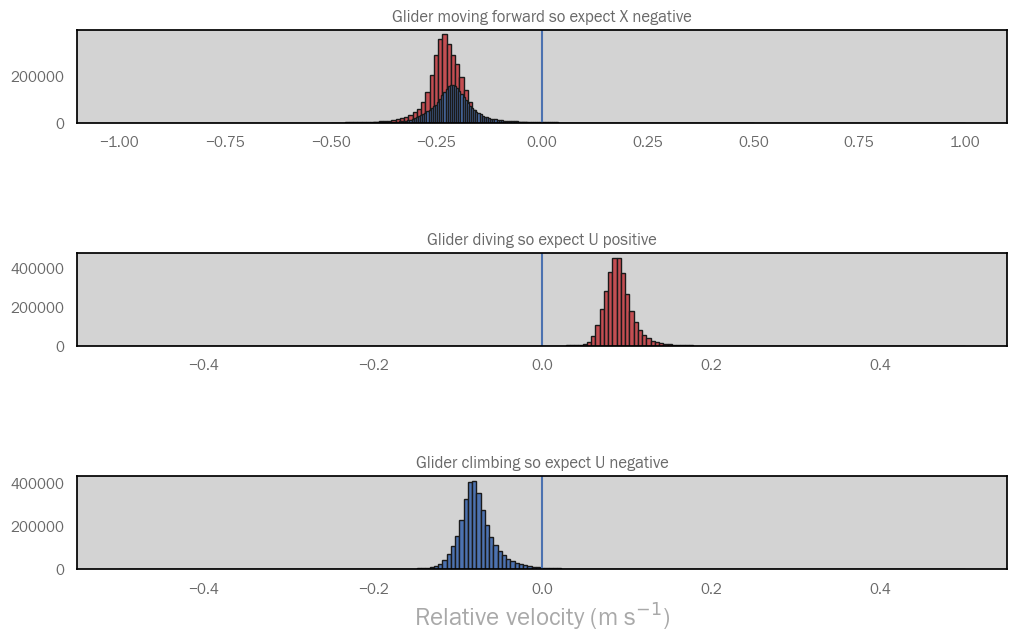

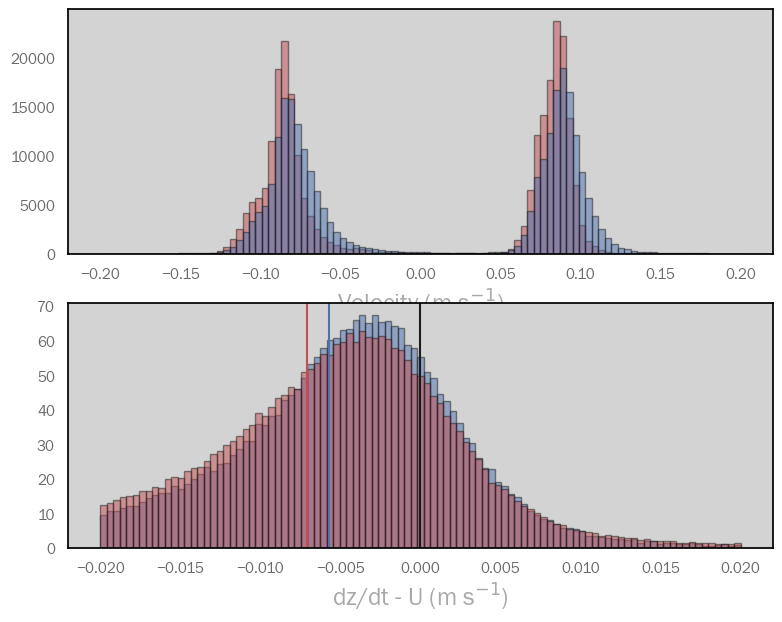

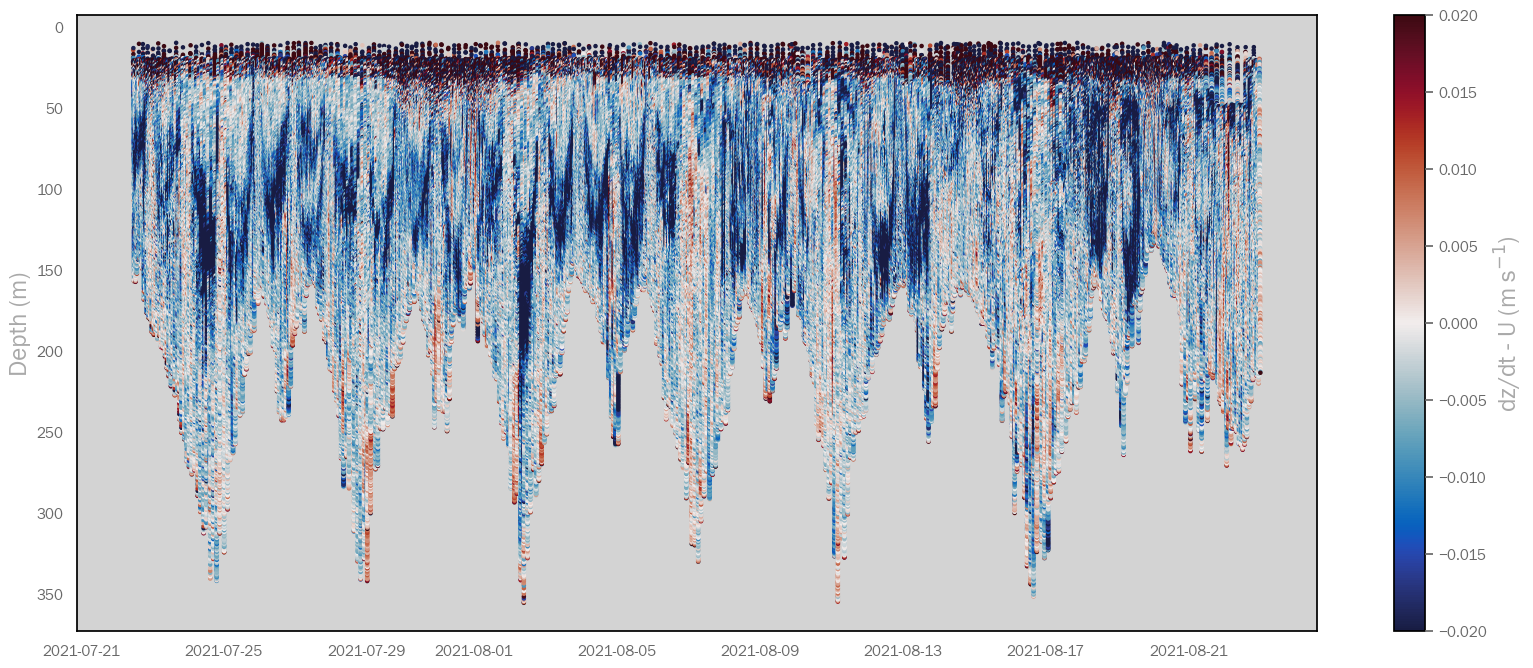

In [16]:
process_adcp.verify_calcENUfromXYZ(ADCP, options)

### Mismatch above sign of misalignment of ADCP / incorrect pitch/roll ?

## 3.7. Grid shear

/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:130: FutureWarning: The provided callable <function nanmean at 0x7f14685c27a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  _tmp = raw.groupby(['xbins', 'ybins'])['v'].agg(fn)
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:130: FutureWarning: The provided callable <function nanstd at 0x7f14685c34c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
  _tmp = raw.groupby(['xbins', 'ybins'])['v'].agg(fn)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.64it/s]


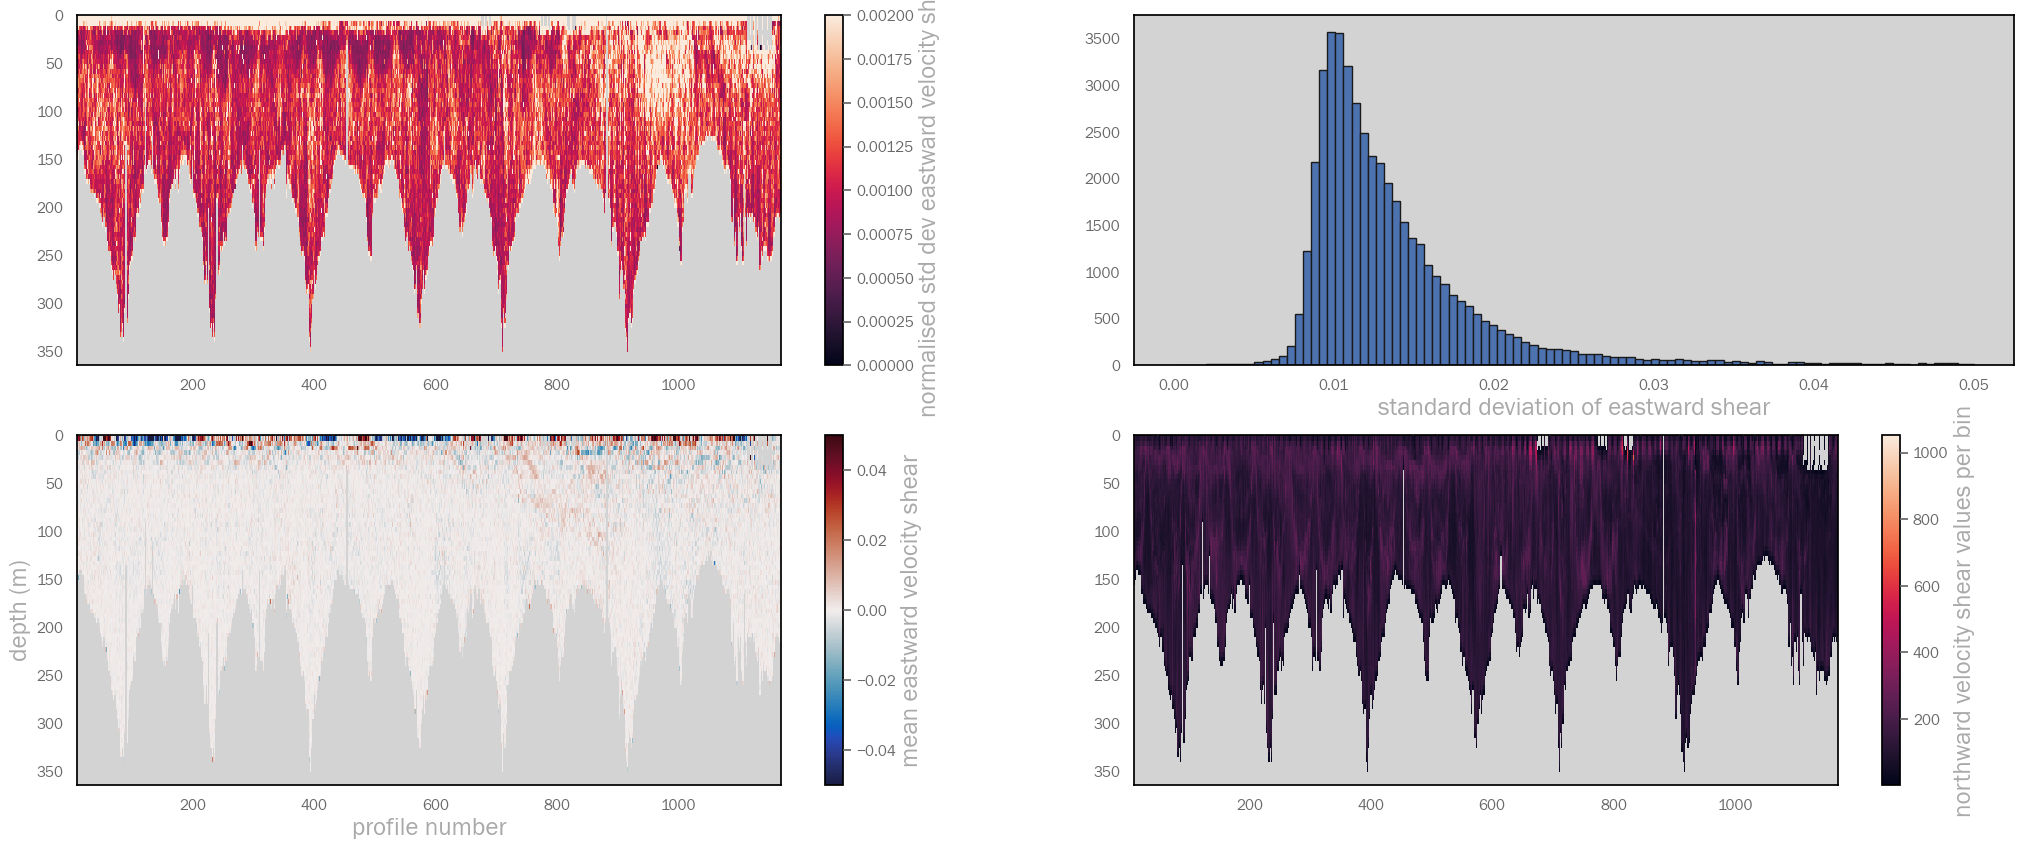

In [17]:
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)
out = process_adcp.grid_data(ADCP, data, {}, xaxis, yaxis)
ds = process_adcp.make_dataset(out)

# 3.8 Write out data

**ds** is an xarray dataset of data gridded by depth bin and profile number, ready for processing

In [18]:
ds

<xarray.Dataset>
Dimensions:           (depth_bin: 357, profile_num: 1159)
Coordinates:
  * profile_num       (profile_num) int64 0 1 2 3 4 ... 1154 1155 1156 1157 1158
  * depth_bin         (depth_bin) int64 0 1 2 3 4 5 ... 351 352 353 354 355 356
Data variables: (12/16)
    Sh_E              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_N              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_U              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Heading           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Pitch             (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Roll              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    ...                ...
    temperature       (depth_bin, profile_num) float64 nan nan nan ... nan nan
    salinity          (depth_bin, profile_num) float64 nan nan nan ... nan nan
    pressure          (depth_bin, profile_num) float64 nan nan nan ... nan nan
    date_float        (depth_bin, profile_num) float64 nan nan nan ... nan nan
    soundspeed        (depth_bin, profile_num) float64 nan nan nan ... nan nan
    profile_datetime  (profile_num) datetime64[ns] 2021-07-22T12:31:03.349361...